In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
import math
from collections import Counter
from itertools import product


Импортируем датасеты

In [2]:
df_iris = pd.read_csv('iris.csv')
df_adm = pd.read_csv('admission.csv')

In [3]:
X = df_iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
y = df_iris['species']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

sampling_strategy_dict = {0: 200, 1: 200, 2: 200}

smote = SMOTE(sampling_strategy=sampling_strategy_dict, random_state=42, k_neighbors=10)
X_resampled, y_resampled_encoded = smote.fit_resample(X, y_encoded)

y_resampled = le.inverse_transform(y_resampled_encoded)

df_iris_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_iris_resampled['species'] = y_resampled

print("\nРаспределение классов после оверсэмплинга:\n", df_iris_resampled['species'].value_counts())
print("\nНовый размер датасета:", df_iris_resampled.shape)


Распределение классов после оверсэмплинга:
 species
Iris-setosa        200
Iris-versicolor    200
Iris-virginica     200
Name: count, dtype: int64

Новый размер датасета: (600, 5)


**КЛАССИФИКАЦИЯ**

**Бейзлайн**

Разделим датасет на две части и обучим дефолтный классификатор на основе градиентного бустинга

In [35]:
X_cls = df_iris_resampled.drop('species', axis=1)
y_cls = df_iris_resampled['species']
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

In [36]:
gb_clf_base = GradientBoostingClassifier(random_state=42)
gb_clf_base.fit(X_train_cls, y_train_cls)
y_pred_cls_base = gb_clf_base.predict(X_test_cls)

In [37]:
acc_base = accuracy_score(y_test_cls, y_pred_cls_base)
print(f"Classification Accuracy: {acc_base:.4f}")

Classification Accuracy: 0.9500


В результате получили хорошее значение метрики. Попробуем его улучшить, сгенерировав новый признак, и подобрав на сетке с кросс-валидацией гиперпараметры

Посмотрим на важность признаков. Пока что важны только два, попробуем сделать какой-нибудь новый.

Посмотрим, с какими гиперпараметрами был обучен классификатор

In [92]:
gb_clf_base.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

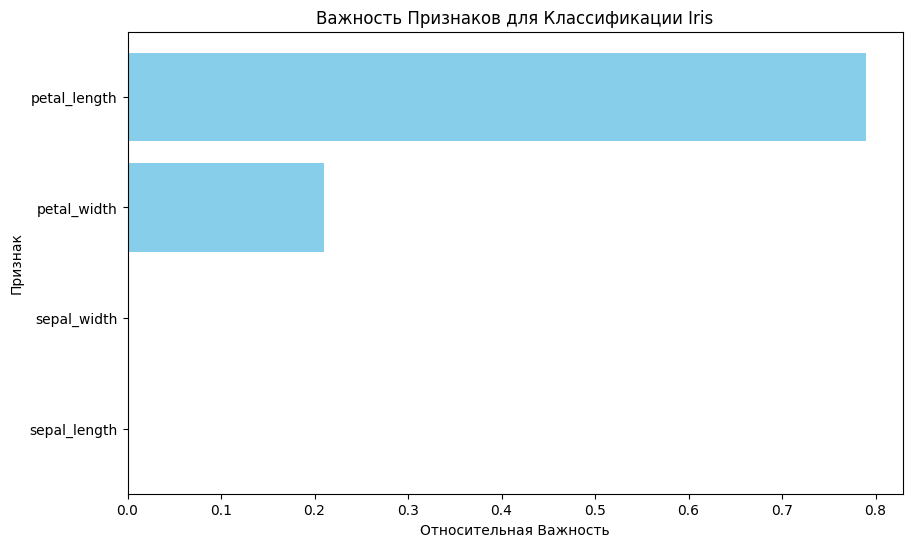

In [86]:
importances = gb_clf_base.feature_importances_
feature_names = X_train_cls.columns

feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Относительная Важность')
plt.ylabel('Признак')
plt.title('Важность Признаков для Классификации Iris')
plt.gca().invert_yaxis() 
plt.show()

**Улучшения**

Аналогично разделим выборку на две части

In [38]:
X_train_cls_eng = X_train_cls.copy()
X_test_cls_eng = X_test_cls.copy()
X_train_cls_eng['petal_ratio'] = X_train_cls_eng['petal_length'] / X_train_cls_eng['petal_width']
X_test_cls_eng['petal_ratio'] = X_test_cls_eng['petal_length'] / X_test_cls_eng['petal_width']

Попробуем найти оптимальные гиперпараметры. В случае градиентного бустинга логичнее всего построить множество невысоких деревьев, ведь алгоритм каждое последующее дерево строит на ошибках предыдущего, и алгоритм будет работать неэффективно, если все деревья будет очень глубокими. Градиентный бустинг в отличие от случайного леса склонен к переобучению.

In [89]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [1, 3, 5],
    'subsample': [0.8, 1.0]
}

In [90]:
grid_cls = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_cls.fit(X_train_cls_eng, y_train_cls)

best_model_cls = grid_cls.best_estimator_
print(f"Best Params Iris: {grid_cls.best_params_}")

Best Params Iris: {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 200, 'subsample': 1.0}


In [91]:
y_pred_cls_tuned = best_model_cls.predict(X_test_cls_eng)
acc_tuned = accuracy_score(y_test_cls, y_pred_cls_tuned)
print(f"Classification Best Accuracy: {acc_tuned:.4f}")

Classification Best Accuracy: 0.9583


Мы получили незначительное, но увеличение метрики. Можно видеть разницу в глубине деревьев. По умолчанию она была 3, сейчас этот гиперпараметр равен 1

Посмотрим на то, насколько важным оказался новый признак - соотношение сторон

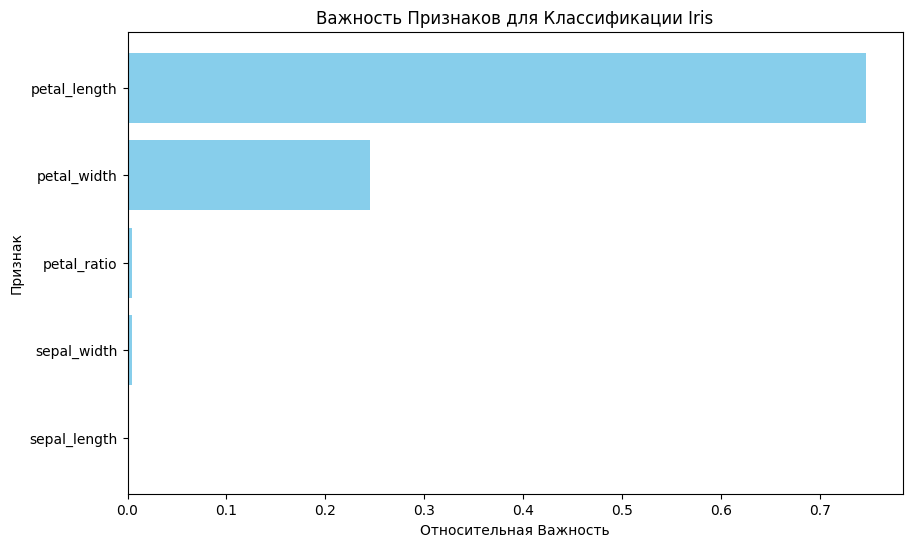

In [59]:
importances = best_model_cls.feature_importances_
feature_names = X_train_cls_eng.columns

feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Относительная Важность')
plt.ylabel('Признак')
plt.title('Важность Признаков для Классификации Iris')
plt.gca().invert_yaxis() 
plt.show()

Признак оказался не очень важным, для разделения важны все те же признаки, что и были в дефолтной модели

**РЕГРЕССИЯ**

**Бейзлайн**

Разделим выборку

In [78]:
df_adm.columns = [c.strip() for c in df_adm.columns]
X_reg = df_adm.drop(['Serial No.', 'Chance of Admit'], axis=1)
y_reg = df_adm['Chance of Admit']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

Обучим на классификаторе по умолчанию

In [79]:
gb_reg_base = GradientBoostingRegressor(random_state=42)
gb_reg_base.fit(X_train_reg, y_train_reg)
y_pred_reg_base = gb_reg_base.predict(X_test_reg)

In [80]:
r2_base = r2_score(y_test_reg, y_pred_reg_base)
mae_base = mean_absolute_error(y_test_reg, y_pred_reg_base)

print(f"Regression R2:     {r2_base:.4f}")
print(f"Regression MAE:    {mae_base:.4f}")

Regression R2:     0.7955
Regression MAE:    0.0502


In [95]:
gb_reg_base.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Мы получили хорошее значение метрики, попробуем улучшить ее, подобрав гиперпараметры на сетке с кросс-валидацией, а так же посмотрим на важность признаков.

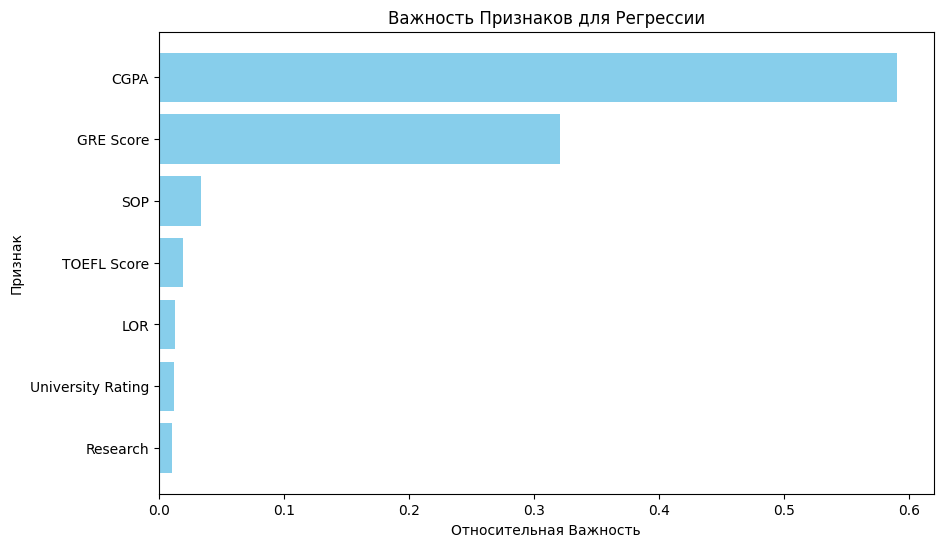

In [102]:
importances = gb_reg_base.feature_importances_
feature_names = X_train_reg.columns

feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Относительная Важность')
plt.ylabel('Признак')
plt.title('Важность Признаков для Регрессии')
plt.gca().invert_yaxis() 
plt.show()

**Улучшения**

Как всегда разделим выборку на две части и определим сетку гиперпараметров

In [81]:
X_train_reg_eng = X_train_reg.copy()
X_test_reg_eng = X_test_reg.copy()

In [96]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [1, 3, 5],
    'subsample': [0.8, 1.0]
}

Найдем оптимальные гиперпараметры

In [97]:
grid_reg = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_reg.fit(X_train_reg_eng, y_train_reg)

best_model_reg = grid_reg.best_estimator_
print(f"Best Params Admissions: {grid_reg.best_params_}")

Best Params Admissions: {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 300, 'subsample': 1.0}


In [98]:
y_pred_reg_tuned = best_model_reg.predict(X_test_reg_eng)

r2_tuned = r2_score(y_test_reg, y_pred_reg_tuned)
mae_tuned = mean_absolute_error(y_test_reg, y_pred_reg_tuned)

In [99]:
print(f"Regression tuned R2:     {r2_tuned:.4f}")
print(f"Regression tuned MAE:    {mae_tuned:.4f}")

Regression tuned R2:     0.8125
Regression tuned MAE:    0.0478


Видим, что метрика незначительно, но увеличилась. Это подтверждает важность правильного подбора гиперпараметров. Так же мы снова видим, что в алгоритме градиентного бустинга нужно много эстиматоров, каждый из которых неглубокий. Посмотрим на важность признаков.

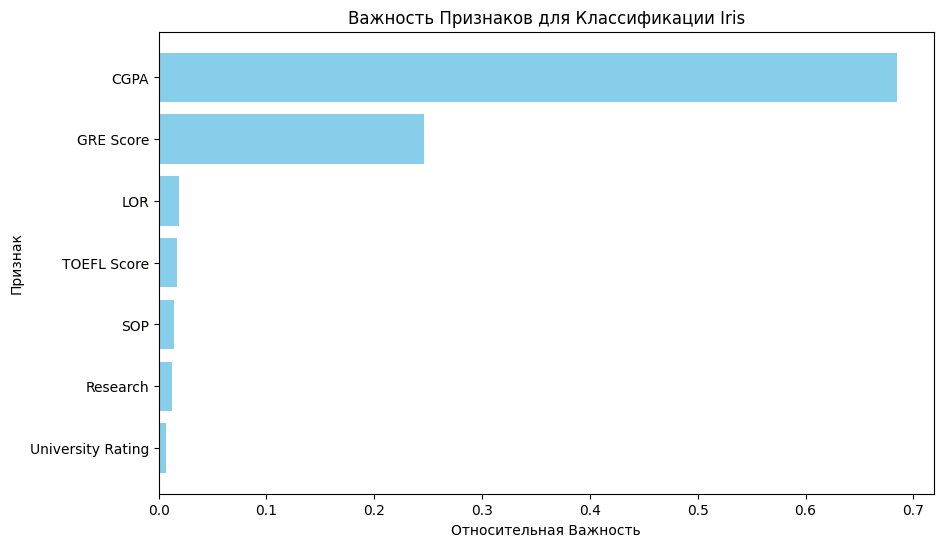

In [103]:
importances = best_model_reg.feature_importances_
feature_names = X_train_reg_eng.columns

feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Относительная Важность')
plt.ylabel('Признак')
plt.title('Важность Признаков для Классификации Iris')
plt.gca().invert_yaxis() 
plt.show()

**ИМПЛЕМЕНТАЦИЯ**

Используем код дерева решений из прошлой работы

In [4]:
class TreeNode:
    def __init__(self, *, feature_idx=None, threshold=None, left=None, right=None, value=None, is_leaf=False):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.is_leaf = is_leaf

class DecisionTree:
    def __init__(self, task='classification', max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=None, max_features=None):
        assert task in ('classification', 'regression')
        self.task = task
        self.max_depth = None if max_depth is None else int(max_depth)
        self.min_samples_split = int(min_samples_split)
        self.min_samples_leaf = int(min_samples_leaf)
        self.root = None
        self.random_state = random_state
        self._rng = np.random.RandomState(random_state)
        self.max_features = max_features 

    def _gini(self, y):
        if len(y) == 0:
            return 0
        vals, counts = np.unique(y, return_counts=True)
        probs = counts / counts.sum()
        return 1 - np.sum(probs**2)

    def _mse(self, y):
        if len(y) == 0:
            return 0
        return np.mean((y - np.mean(y))**2)

    def _best_split(self, X, y):
        n_samples, n_features = X.shape
        if self.max_features is None:
            feature_indices = range(n_features)
        else:
            k = self.max_features
            k = max(1, min(n_features, int(k)))
            feature_indices = self._rng.choice(n_features, k, replace=False)
        best_feat, best_thresh, best_gain = None, None, -np.inf
        current_impurity = self._gini(y) if self.task == 'classification' else self._mse(y)

        for feat in feature_indices:
            col = X[:, feat]
            unique_values = np.unique(col)
            if unique_values.shape[0] == 1:
                continue
            thresholds = (unique_values[:-1] + unique_values[1:]) / 2.0
            for thresh in thresholds:
                left_mask = col <= thresh
                right_mask = ~left_mask
                if left_mask.sum() < self.min_samples_leaf or right_mask.sum() < self.min_samples_leaf:
                    continue
                if self.task == 'classification':
                    left_imp = self._gini(y[left_mask])
                    right_imp = self._gini(y[right_mask])
                    n_left = left_mask.sum()
                    n_right = right_mask.sum()
                    weighted_impurity = (n_left * left_imp + n_right * right_imp) / (n_left + n_right)
                    gain = current_impurity - weighted_impurity
                else:
                    left_imp = self._mse(y[left_mask])
                    right_imp = self._mse(y[right_mask])
                    n_left = left_mask.sum()
                    n_right = right_mask.sum()
                    weighted_impurity = (n_left * left_imp + n_right * right_imp) / (n_left + n_right)
                    gain = current_impurity - weighted_impurity

                if gain > best_gain:
                    best_gain = gain
                    best_feat = feat
                    best_thresh = thresh

        return best_feat, best_thresh, best_gain

    def _build_tree(self, X, y, depth=0):
        n_samples = X.shape[0]

        if n_samples == 0:
            return TreeNode(is_leaf=True, value=None)
        if self.max_depth is not None and depth >= self.max_depth:
            return TreeNode(is_leaf=True, value=self._leaf_value(y))
        if n_samples < self.min_samples_split:
            return TreeNode(is_leaf=True, value=self._leaf_value(y))
        if self.task == 'classification':
            if len(np.unique(y)) == 1:
                return TreeNode(is_leaf=True, value=self._leaf_value(y))
        else:
            if np.allclose(y, y[0]):
                return TreeNode(is_leaf=True, value=self._leaf_value(y))

        feat, thresh, gain = self._best_split(X, y)
        if feat is None or gain <= 0:
            return TreeNode(is_leaf=True, value=self._leaf_value(y))

        left_mask = X[:, feat] <= thresh
        right_mask = ~left_mask

        left_node = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_node = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        return TreeNode(feature_idx=feat, threshold=thresh, left=left_node, right=right_node, is_leaf=False)

    def _leaf_value(self, y):
        if len(y) == 0:
            return None
        if self.task == 'classification':
            most_common = Counter(y).most_common(1)[0][0]
            return most_common
        else:
            return np.mean(y)

    def fit(self, X_df, y_sr):
        X = X_df.values.astype(float)
        y = y_sr.values
        n_features = X.shape[1]
        if self.max_features is None:
            if self.task == 'classification':
                self.max_features = max(1, int(math.sqrt(n_features)))
            else:
                self.max_features = n_features
        self.root = self._build_tree(X, y, depth=0)

    def _predict_one(self, x, node):
        if node.is_leaf:
            return node.value
        if x[node.feature_idx] <= node.threshold:
            return self._predict_one(x, node.left)
        else:
            return self._predict_one(x, node.right)

    def predict(self, X_df):
        X = X_df.values.astype(float)
        preds = np.array([self._predict_one(x, self.root) for x in X])
        return preds

Так же используем вспомогательные фукнции из прошлой работы

In [5]:
def calculate_accuracy(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    total_samples = len(y_true)
    return correct_predictions / total_samples

def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def calculate_r2(y_true, y_pred):
    y_mean = np.mean(y_true)
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - y_mean)**2)
    if ss_tot == 0:
        return 1.0
    return 1 - (ss_res / ss_tot)

def train_test_split(X, y, test_size=0.3, random_state=42):
    np.random.seed(random_state)
    n_samples = X.shape[0]
    n_test = int(n_samples * test_size)
    indices = np.random.permutation(n_samples)
    test_indices = indices[:n_test]
    train_indices = indices[n_test:]
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
    return X_train, X_test, y_train, y_test

def custom_k_fold_split(X, y, n_splits=5, random_state=42):
    np.random.seed(random_state)
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=int)
    fold_sizes[:n_samples % n_splits] += 1
    
    current = 0
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        test_indices = indices[start:stop]
        train_indices = np.concatenate([indices[:start], indices[stop:]])
        yield (train_indices, test_indices)
        current = stop

def custom_grid_search(X_train, y_train, model_class, param_grid,
                       n_splits=5, scoring='r2'):
    
    maximize_metrics = {'accuracy', 'r2', 'f1'}
    minimize_metrics = {'mae', 'mse'}
    
    if scoring in maximize_metrics:
        compare = lambda new, best: new > best
        best_score = -np.inf
    elif scoring in minimize_metrics:
        compare = lambda new, best: new < best
        best_score = np.inf
    else:
        raise ValueError(f"Метрика '{scoring}' не поддерживается")

    best_params = None

    keys, values = zip(*param_grid.items())
    
    for params in product(*values):
        param_dict = dict(zip(keys, params))
        fold_scores = []

        for tr_idx, val_idx in custom_k_fold_split(X_train, y_train, n_splits=n_splits):
            X_tr = X_train.iloc[tr_idx]
            X_val = X_train.iloc[val_idx]
            
            y_tr = y_train.iloc[tr_idx]
            y_val = y_train.iloc[val_idx]

            model = model_class(**param_dict)
            model.fit(X_tr, y_tr)
            pred = model.predict(X_val)

            if scoring == 'r2':
                score = calculate_r2(y_val.values, pred)
            elif scoring == 'mae':
                score = calculate_mae(y_val.values, pred)
            elif scoring == 'accuracy':
                score = np.mean(y_val.values == pred)
            else:
                raise ValueError(f"Метрика '{scoring}' не поддерживается")

            fold_scores.append(score)

        mean_score = np.mean(fold_scores)

        print(f"{param_dict} -> {scoring}={mean_score:.4f}")

        if compare(mean_score, best_score):
            best_score = mean_score
            best_params = param_dict

    return best_params, best_score

**КЛАССИФИКАЦИЯ**

Реализуем класс градиентного бустинга

In [6]:
class GradientBoostingClassifierCustom:
    def __init__(self, n_estimators=100, max_depth=3, min_samples_split=2, min_samples_leaf=1,
                 learning_rate=0.1, random_state=None, max_features=None):

        self.n_estimators = int(n_estimators)
        self.max_depth = None if max_depth is None else int(max_depth)
        self.min_samples_split = int(min_samples_split)
        self.min_samples_leaf = int(min_samples_leaf)
        self.learning_rate = float(learning_rate)
        self.random_state = random_state
        self.classes_ = None
        self.class_models = {}
        self.init_F = {}
        self.max_features = max_features

    @staticmethod
    def _sigmoid(x):
        return 1.0 / (1.0 + np.exp(-np.clip(x, -20, 20)))

    def fit(self, X_df, y_sr):
        X = X_df.copy().reset_index(drop=True)
        y = y_sr.copy().reset_index(drop=True).values
        self.classes_, inv = np.unique(y, return_inverse=True)
        n_classes = len(self.classes_)
        rng = np.random.RandomState(self.random_state)

        self.class_models = {}
        self.init_F = {}

        Y_onehot = np.zeros((len(y), n_classes))
        for i, cls in enumerate(self.classes_):
            Y_onehot[:, i] = (y == cls).astype(float)

        class_priors = Y_onehot.mean(axis=0)
        for k, p in enumerate(class_priors):
            p = np.clip(p, 1e-6, 1-1e-6)
            self.init_F[self.classes_[k]] = math.log(p / (1 - p))

        for k_idx, cls in enumerate(self.classes_):
            Fk = np.full(len(y), self.init_F[cls])
            trees = []
            for m in range(self.n_estimators):
                pk = self._sigmoid(Fk)
                residual = Y_onehot[:, k_idx] - pk
                tree = DecisionTree(task='regression',
                                    max_depth=self.max_depth,
                                    min_samples_split=self.min_samples_split,
                                    min_samples_leaf=self.min_samples_leaf,
                                    random_state=rng.randint(0, 2**31-1),
                                    max_features=self.max_features)
                tree.fit(X, pd.Series(residual))
                update = tree.predict(X)
                Fk = Fk + self.learning_rate * update
                trees.append(tree)
            self.class_models[cls] = trees

    def predict_proba(self, X_df):
        X = X_df.copy().reset_index(drop=True)
        n_samples = X.shape[0]
        K = len(self.classes_)
        raw = np.zeros((n_samples, K))
        for k_idx, cls in enumerate(self.classes_):
            Fk = np.full(n_samples, self.init_F[cls])
            for tree in self.class_models[cls]:
                Fk = Fk + self.learning_rate * tree.predict(X)
            raw[:, k_idx] = Fk
        probs = self._sigmoid(raw)
        row_sums = probs.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1.0
        probs = probs / row_sums
        return probs

    def predict(self, X_df):
        probs = self.predict_proba(X_df)
        idx = np.argmax(probs, axis=1)
        return self.classes_[idx]

**Бейзлайн**

Для бейзлайна разделим выборку на две части и обучим самописный классификатор на гиперпараметрах по-умолчанию

In [7]:
X_cls = df_iris_resampled.drop('species', axis=1)
y_cls = df_iris_resampled['species']
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

In [8]:
clf = GradientBoostingClassifierCustom(n_estimators=50, max_depth=3, min_samples_split=2, min_samples_leaf=1, learning_rate=0.1, random_state=42)
clf.fit(X_train_c, y_train_c)
preds_c = clf.predict(X_test_c)
acc = calculate_accuracy(y_test_c.values, preds_c)
print(f"Classification accuracy : {acc:.4f}")

Classification accuracy : 0.9500


В результате мы получили в точности такой же результат, как и в классификаторе из коробки в библиотеке. Это хороший результат классификации, попробуем улучшить его с помощью подбора оптимальных гиперпараметров

**Улучшения**

Найдем оптимальные гиперпараметры по сетке с кросс-валидацией

In [9]:
param_grid_clf = {
        'n_estimators': [20, 50],
        'max_depth': [2, 3],
        'min_samples_split': [2],
        'min_samples_leaf': [1],
        'learning_rate': [0.05, 0.1]
    }
best_params_clf, best_score_clf = custom_grid_search(X_train_c.reset_index(drop=True), y_train_c.reset_index(drop=True),
                                                     GradientBoostingClassifierCustom, param_grid_clf, n_splits=3, scoring='accuracy')
print("Best params for classification:", best_params_clf, "score:", best_score_clf)


{'n_estimators': 20, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 1, 'learning_rate': 0.05} -> accuracy=0.9833
{'n_estimators': 20, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 1, 'learning_rate': 0.1} -> accuracy=0.9833
{'n_estimators': 20, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'learning_rate': 0.05} -> accuracy=0.9958
{'n_estimators': 20, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'learning_rate': 0.1} -> accuracy=0.9958
{'n_estimators': 50, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 1, 'learning_rate': 0.05} -> accuracy=0.9833
{'n_estimators': 50, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 1, 'learning_rate': 0.1} -> accuracy=0.9875
{'n_estimators': 50, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'learning_rate': 0.05} -> accuracy=0.9958
{'n_estimators': 50, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'learning_rate': 0.1} -> accuracy=0.9

In [13]:
final_clf = GradientBoostingClassifierCustom(**best_params_clf, random_state=42)
final_clf.fit(X_train_c, y_train_c)
final_preds_c = final_clf.predict(X_test_c)
final_acc = calculate_accuracy(y_test_c.values, final_preds_c)
print(f"Final test accuracy: {final_acc:.4f}")

Final test accuracy: 0.9500


Мы не улучшилили нашу метрику после поиска оптимальных гиперпараметров. Я могу все так же обьяснить это простотой нашего датасета и хорошую разделимость каждого класса. Кроме того, сама по себе точность в 95 процентов - это отличная метрика, улучшать которую не всегда стоит, чтобы исключить переобучение модели.

**РЕГРЕССИЯ**

Реализуем кастомный регрессор на основе градиентного бустинга

In [127]:
class GradientBoostingRegressorСustom:
    def __init__(self, n_estimators=100, max_depth=3, min_samples_split=2, min_samples_leaf=1,
                 learning_rate=0.1, random_state=None, max_features=None):
        self.n_estimators = int(n_estimators)
        self.max_depth = None if max_depth is None else int(max_depth)
        self.min_samples_split = int(min_samples_split)
        self.min_samples_leaf = int(min_samples_leaf)
        self.learning_rate = float(learning_rate)
        self.random_state = random_state
        self.trees = []
        self.init_pred = None
        self.max_features = max_features

    def fit(self, X_df, y_sr):
        X = X_df.copy().reset_index(drop=True)
        y = y_sr.copy().reset_index(drop=True).values.astype(float)
        n_samples = X.shape[0]

        self.init_pred = np.mean(y)
        y_pred = np.full(n_samples, self.init_pred)

        rng = np.random.RandomState(self.random_state)
        self.trees = []
        for m in range(self.n_estimators):
            residual = y - y_pred
            tree = DecisionTree(task='regression',
                                max_depth=self.max_depth,
                                min_samples_split=self.min_samples_split,
                                min_samples_leaf=self.min_samples_leaf,
                                random_state=rng.randint(0, 2**31-1),
                                max_features=self.max_features)
            tree.fit(X, pd.Series(residual))
            update = tree.predict(X) 
            y_pred = y_pred + self.learning_rate * update
            self.trees.append(tree)

    def predict(self, X_df):
        X = X_df.copy().reset_index(drop=True)
        n_samples = X.shape[0]
        y_pred = np.full(n_samples, self.init_pred)
        for tree in self.trees:
            y_pred = y_pred + self.learning_rate * tree.predict(X)
        return y_pred

**Бейзлайн**

Для бейзлайна просто разделим выборку на две части и обучим наш регрессор

In [117]:
df_adm.columns = [c.strip() for c in df_adm.columns]
X_reg = df_adm.drop(['Serial No.', 'Chance of Admit'], axis=1)
y_reg = df_adm['Chance of Admit']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

In [119]:
reg = GradientBoostingRegressorСustom(n_estimators=100, max_depth=3, min_samples_split=2, min_samples_leaf=1,
                                    learning_rate=0.1, random_state=42)
reg.fit(X_train_r, y_train_r)
preds_r = reg.predict(X_test_r)
r2 = calculate_r2(y_test_r.values, preds_r)
mae = calculate_mae(y_test_r.values, preds_r)
print(f"Regression R2: {r2:.4f}, MAE: {mae:.4f}")

Regression R2: 0.7949, MAE: 0.0502


Отлично, попробуем хотя бы незначительно улучшить метрику

**Улучшения**

Попробуем найти оптимальные гиперпараметры для градиентного бустинга на кросс-валидации

In [123]:
param_grid_reg = {
        'n_estimators': [50, 100],
        'max_depth': [2, 3],
        'min_samples_split': [2],
        'min_samples_leaf': [1],
        'learning_rate': [0.05, 0.1]
    }
best_params_reg, best_score_reg = custom_grid_search(X_train_r.reset_index(drop=True), y_train_r.reset_index(drop=True),
                                                     GradientBoostingRegressorСustom, param_grid_reg, n_splits=3, scoring='r2')
print("Best params for regression:", best_params_reg, "score:", best_score_reg)

{'n_estimators': 50, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 1, 'learning_rate': 0.05} -> r2=0.7362
{'n_estimators': 50, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 1, 'learning_rate': 0.1} -> r2=0.7416
{'n_estimators': 50, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'learning_rate': 0.05} -> r2=0.7343
{'n_estimators': 50, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'learning_rate': 0.1} -> r2=0.7275
{'n_estimators': 100, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 1, 'learning_rate': 0.05} -> r2=0.7392
{'n_estimators': 100, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 1, 'learning_rate': 0.1} -> r2=0.7281
{'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'learning_rate': 0.05} -> r2=0.7325
{'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'learning_rate': 0.1} -> r2=0.7030
Best params for regression: {'n_estimato

Обучим полученный классификатор с лучшими парамтрами, найденными на сетке с кросс-валидацией

In [125]:
final_reg = GradientBoostingRegressorСustom(**best_params_reg, random_state=42)
final_reg.fit(X_train_r, y_train_r)
final_preds_r = final_reg.predict(X_test_r)
final_r2 = calculate_r2(y_test_r.values, final_preds_r)
final_mae = calculate_mae(y_test_r.values, final_preds_r)
print(f"Improved regression R2: {final_r2:.4f}, MAE: {final_mae:.4f}")

Improved regression R2: 0.8107, MAE: 0.0478


Мы улучшили результаты классификатора, подобрав оптимальные гиперпараметры на сетке. В сравнении с библиотечной реализацией наша решализация не проигрывает. В библиотечной реализации была получена похожая метрика в 0.81 и 0.05

**ОБЩИЕ РЕЗУЛЬТАТЫ:**

В течение курса мною были выполнены пять лабораторных работ, целью которых было применить на практических задачах регрессии и классификацииразличные методы машинного обученя.  
Первая работа была направлена на изучение метода KNN.  Суть алгоритма **KNN** заключается не в построении какой-либо глобальной модели, как в случае с линейными моделями или деревьями, а в использовании локального подхода: для предсказания значения или класса новой точки данных алгоритм просто ищет k ближайших к ней точек из обучающего набора. В задаче классификации k-NN присваивает новой точке класс, который является наиболее частым среди ее k ближайших соседей. В задаче регрессии алгоритм предсказывает значение как среднее арифметическое значений целевой переменной у этих k соседей. На практике KNN может давать хорошие результаты, особенно когда границы классов или регрессионная зависимость имеют сложную, но локально-структурированную форму.  
Во второй и третьей работе были проведены эксперементы с **линейными алгоритмами** - линейной и логистической регрессией. Суть алгоритма **линейной регрессии** в построении регрессионной прямой через облако точек данных так, чтобы минимизировать функцию ошибки, которая пропорциональна сумме расстояний от точек до прямой. Этот алгоритм не обладает большой выразительной способностью из-за своей линейной природы. Аналогично **логистическая регрессия** строит линейную поверхность, которая делит облако точек на две части, тем самым относительно которой создается порог классификации на основе удаленности точек от нее. Эти алгоритмы показывали хорошую точность классификации и регрессии, но чтобы улучшить эти показатели, необходимо пользоваться нелинейными алгоритмами.  
В следующей работе я использовал дерево решений для решения задач классификации. **Дерево решений** строит нелинейную кусочно-заданную поверхность на основе критерия разделения. На каждом шаге пространство данных делится на части по определенному критерию. В случае регрессии сплит происходит так, чтобы минимизировать расстояния от точек до поверхности предсказания, а в задачах регрессии сплит делит данные так, чтобы уменьшить меру хаоса в них - энтропию. Дерево решений очень склонно к переобучению, если строить его неограниченно. Переобученное дерево очень глубокое и имеет много листов, причем переобученность может дойти до того, что в каждом листе будет по одному экземпляру обучающих данных.  Дерево решений способно строить нелинейные поверхности, поэтому для нас это свойство позволило улучшить метрики.  
Следущим этапом было использование ансамблевых алгоритмов, а именно случайного леса и градиентного бустинга. Ансамблевые алгоритмы используются для улучшения выразительной способности отдельных деревьев - эстиматоров. **Случайный лес** строит несколько деревьев на подвыборках данных и подвыборках признаков, а потом усредняет их показания. Смысл случайного леса - построить шумные и глубокие, т.е переобученные деревья, а потом усреднить этот шум, ведь теоретически наши данные имеют нормальный шум относительно теоретического решения, а значит усредняя решения, построенные на разных подвыборках, мы приблизимся к эталоному решению. Следовательно случайный лес отлично решает проблему переобучения дерева решений. У градиентного бустинга же другая идея. **Градиентный бустинг** - это линейная комбинация нескольких решений, где каждое последующее строится на ошибках линейной комбинации предыдущих. Таким образом каждое последующее дерево исправляет ошибки предыдущих. Это улучшает выразительную способность модели, но не устраняет свойство переобучаться. В нашей работе самые лучшие результаты я получил используя бустинг и случайный лес.

Результаты классификации:

| Модель                         | Подход                     | Метрика  | Значение |
|--------------------------------|----------------------------|----------|----------|
| KNN                            | Бейзлайн                   | Accuracy | 0.91     |
| KNN                            | Улучшенный бейзлайн        | Accuracy | 0.95     |
| KNN                            | Имплементация              | Accuracy | 0.9833   |
| KNN                            | Улучшенная имплементация   | Accuracy | 1.00     |
| Логистическая регрессия        | Бейзлайн                   | Accuracy | 0.9667   |
| Логистическая регрессия        | Улучшенный бейзлайн        | Accuracy | 0.9667   |
| Логистическая регрессия        | Имплементация              | Accuracy | 1.00     |
| Логистическая регрессия        | Улучшенная имплементация   | Accuracy | 1.00     |
| Дерево классификации           | Бейзлайн                   | Accuracy | 0.9667   |
| Дерево классификации           | Улучшенный бейзлайн        | Accuracy | 0.9667   |
| Дерево классификации           | Имплементация              | Accuracy | 0.9660   |
| Дерево классификации           | Улучшенная имплементация   | Accuracy | 0.9750   |
| Случайный лес                  | Бейзлайн                   | Accuracy | 0.9583   |
| Случайный лес                  | Улучшенный бейзлайн        | Accuracy | 0.9583   |
| Случайный лес                  | Имплементация              | Accuracy | 0.9583   |
| Случайный лес                  | Улучшенная имплементация   | Accuracy | 0.9722   |
| Бустинг                        | Бейзлайн                   | Accuracy | 0.9500   |
| Бустинг                        | Улучшенный бейзлайн        | Accuracy | 0.9583   |
| Бустинг                        | Имплементация              | Accuracy | 0.9500   |
| Бустинг                        | Улучшенная имплементация   | Accuracy | 0.9598   |

Результаты регрессии:  
  
  
| Модель                    | Подход                     | R²     | MAE    |
|---------------------------|----------------------------|--------|--------|
| KNN                       | Бейзлайн                   | 0.7394 | 0.0546 |
| KNN                       | Улучшенный бейзлайн        | 0.7547 | 0.0535 |
| KNN                       | Имплементация              | 0.7394 | 0.0546 |
| KNN                       | Улучшенная имплементация   | 0.7447 | 0.0546 |
| Линейная регрессия        | Бейзлайн                   | 0.7956 | 0.0495 |
| Линейная регрессия        | Улучшенный бейзлайн        | 0.7915 | 0.0498 |
| Линейная регрессия        | Имплементация              | 0.7956 | 0.0495 |
| Линейная регрессия        | Улучшенная имплементация   | 0.8114 | 0.0489 |
| Дерево регрессии          | Бейзлайн                   | 0.5091 | 0.0755 |
| Дерево регрессии          | Улучшенный бейзлайн        | 0.7668 | 0.0524 |
| Дерево регрессии          | Имплементация              | 0.5800 | 0.0700 |
| Дерево регрессии          | Улучшенная имплементация   | 0.7600 | 0.0500 |
| Случайный лес             | Бейзлайн                   | 0.8066 | 0.0498 |
| Случайный лес             | Улучшенный бейзлайн        | 0.8179 | 0.0473 |
| Случайный лес             | Имплементация              | 0.7877 | 0.0496 |
| Случайный лес             | Улучшенная имплементация   | 0.8007 | 0.0483 |
| Бустинг                   | Бейзлайн                   | 0.7955 | 0.0502 |
| Бустинг                   | Улучшенный бейзлайн        | 0.8125 | 0.0478 |
| Бустинг                   | Имплементация              | 0.7949 | 0.0502 |
| Бустинг                   | Улучшенная имплементация   | 0.8107 | 0.0478 |